### <center> Bayes Linear Regression & classic Linear Regression
Этот небольшой проект посвящен сравнению подходов в решении задачи регрессии: байесовского и классического.

Предсказание значений таргета в классической линейной регрессии - это поиск  оптимальной линейной комбинации значений входных признаков ($X_1, X_2, ..., X_n$) с коэффициентами ($w_0, w_1, w_2, ..., w_n$), которые считаются константами и оцениваются с помощью метода наименьших квадратов:
$$Y=w_0 + w_1X_1 + w_2X_2 + ... + w_nX_n + \epsilon \sim N(0, \sigma^2)$$
Принципиальным отличием байесовского подхода является то, что параметры модели является не детерминированными, а случайными величинами, как и данные. Мы, обладая априорными знаниями о распределении параметров модели, с помощью данных (случайных значений признаков и целевой переменной) можем обновить и составить апостериорное распределение параметров:
$$P(w_0, w_1, w_2, ..., w_n|Y,X)=\frac{P(Y|w_0, w_1, w_2, ...,w_n, X) \cdot P(w_0, w_1, w_2, ...,w_n|X)}{P(Y,X)}$$
В результате мы получим не точечные оценки параметров, а плотность их совместного распределения при имеющихся данных и оценить вероятность значений.

In [1]:
# импортируем необходимые библиотеки
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm    # версия 5.20.1
import seaborn as sns
import bambi as bmb
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

 **1.** Загрузим **датасет с данными о стоимости квартир** и решим задачу регрессии с помощью двух подходов: сначала - байесовского, а затем - классической линейной регрессией.

In [2]:
data = pd.read_csv('flats.zip')
data.head()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0


Первый столбец сразу удалим, это ID квартиры и не несет для нас полезной информации.

In [3]:
data = data.drop(['Unnamed: 0'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  6042 non-null   int64  
 1   full_sq    6042 non-null   int64  
 2   life_sq    6042 non-null   float64
 3   num_room   6042 non-null   float64
 4   kitch_sq   6042 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 236.1 KB


In [4]:
data.isna().sum()

price_doc    0
full_sq      0
life_sq      0
num_room     0
kitch_sq     0
dtype: int64

Мы не наблюдаем пропусков, все признаки числовые, поэтому можем сразу перейти к анализу данных.

Наша целевая переменная *price_doc* - стоимость квартиры описывается следующими факторами:
* *full_sq* - общая площадь квартиры;
* *life_sq* - жилая площадь;
* *kitch_sq* - площадь кухни;
* *num_room* - количество комнат.

На качество прогноза в линейной регрессии может сильно повлиять мультиколлинеарность, так как в основном она:
* повышает нестабильность коэффициентов (при сильной корреляции между признаками модель не может однозначно определить влияние каждого из них);
* увеличивается дисперсия оценок коэффициентов, что также приводит к нестабильности предсказаний;
* маленькие изменения в данных приводят к большим изменениям коэффициентов.

**2.** Посмотрим на **корреляционную матрицу наших данных**.

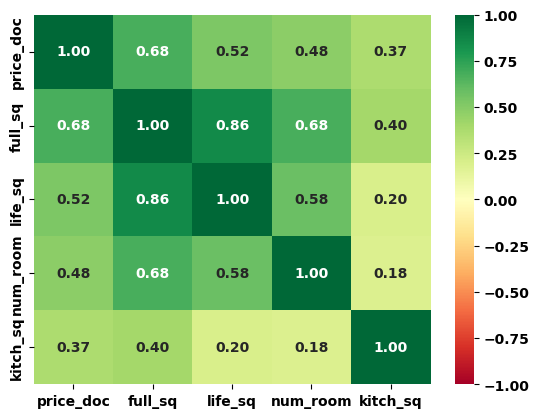

In [5]:
sns.heatmap(data.corr(method='pearson'), cmap='RdYlGn', annot=True, fmt='.2f', vmin=-1, vmax=1, center=0);

Высокую зависимость видим между признаками площади: общей и жилой, мы исключим признак *life_sq* из создания прогноза.

In [6]:
data.drop('life_sq', axis=1, inplace=True)

**3.** Проведем **разведывательный анализ целевой переменной и ее зависимости от факторов**.

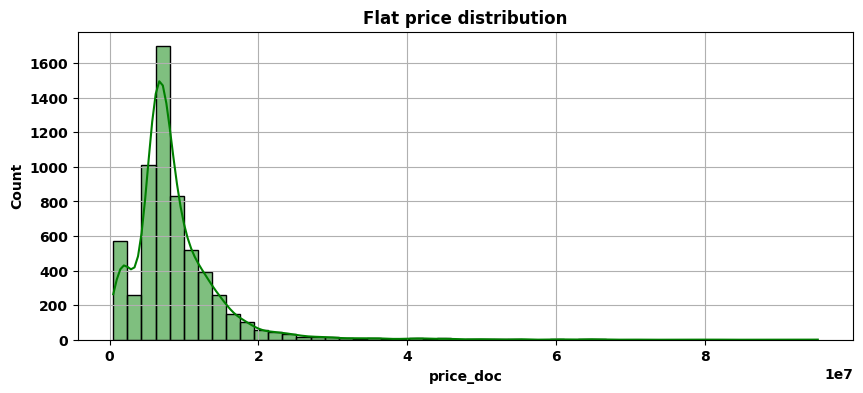

In [7]:
plt.figure(figsize=(10,4))
sns.histplot(data['price_doc'], kde=True, bins=50, color='green')
plt.title('Flat price distribution')
plt.grid()
plt.show()

Наша целевая переменная имеет сильное смещение (далеко от нормального распределения). Применим логарифмирование, чтобы:
1. Уменьшить асимметрию - приблизить к нормальному распеделению.
Мы помним, что линейные модели лучше работают с нормальными распределениями ошибок.
2. Уменьшить дисперсию  (значения целевой переменной сильно варьируются).
3. Снизить влияние выбросов, логарифмирование сглаживает выбросы и уменьшает их влияние на модель.

In [8]:
data['price_log'] = np.log(data['price_doc']) 

Отобразим на графике стоимости квартир уже в логарифмическом масштабе.

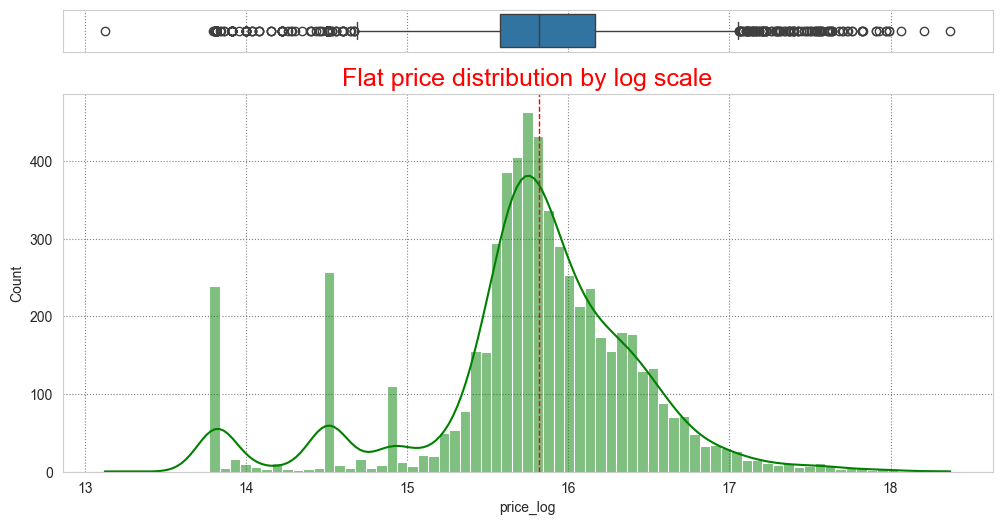

In [9]:
sns.set_style("whitegrid", {"grid.color": ".5", "grid.linestyle": ":"})
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios':{.1, .9}}, figsize=(12, 6)) # задаем размер координатной плоскости и соотношение графиков
# коробчатая диаграмма для определения выбросов, дисперсии
sns.boxplot(data['price_log'], orient="h", ax=ax_box)
# гистограмма
sns.histplot(data['price_log'], kde=True, color='green', ax=ax_hist)
ax_hist.axvline(data['price_log'].median(), color='red', linestyle='--', linewidth=1) # медианное значение
plt.title('Flat price distribution by log scale', fontsize=18, color='r')
plt.show()

Мы наблюдаем очень много выбросов, причем в обе стороны.\
Применим классический метод Тьюки для поиска и удаления выбросов из данных:\
по данному методу выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычитается полтора межквартильных размаха ($Q1 - 1.5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавляется полтора межквартильных размаха ($Q3 + 1.5 * IQR$). 

In [10]:
print(f'Размер данных до удаления выбросов: {data.shape[0]}')

# функция нахождения выбросов по методу Тьюки
def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# применим функцию к логарифмированному значению price
outliers, data = find_outliers_iqr(data, 'price_doc', log_scale=True)
print(f'Размер данных после удаления выбросов: {data.shape[0]}')

Размер данных до удаления выбросов: 6042
Размер данных после удаления выбросов: 5349


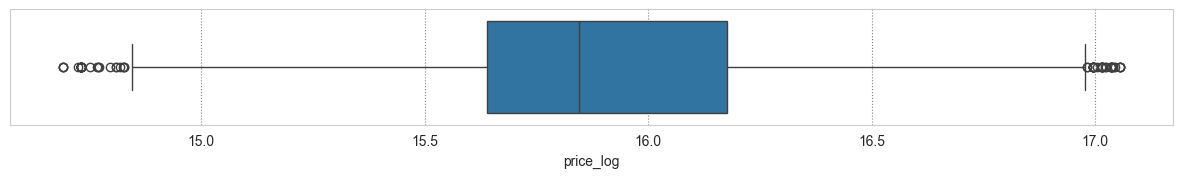

In [11]:
# посмотрим, что у нас после удаления выбросов
plt.figure(figsize=(15, 1.5)) 
sns.boxplot(x=data['price_log'], orient="h")
plt.show()

**4. Распределение цен на квартиры в зависимости от количества комнат**.

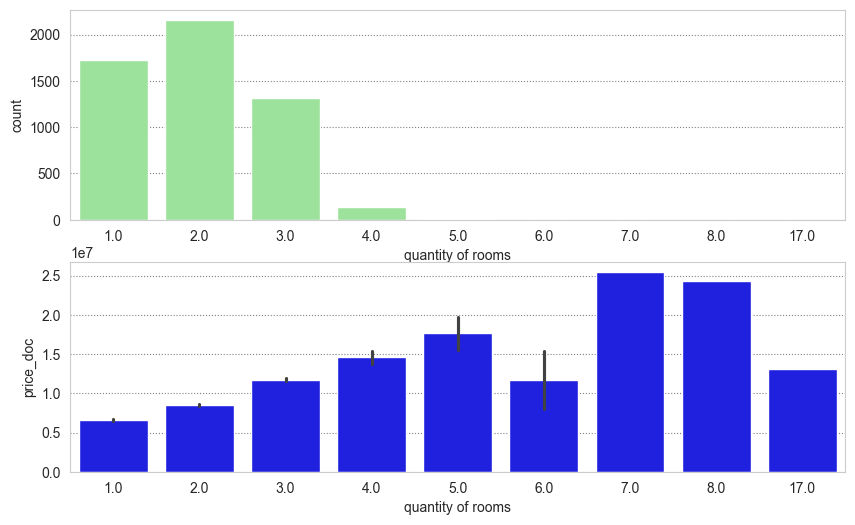

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.countplot(x=data['num_room'], color='lightgreen', ax=ax[0])
ax[0].set_xlabel('quantity of rooms')
sns.barplot(x=data['num_room'], y=data['price_doc'], color='blue', ax=ax[1])
ax[1].set_xlabel('quantity of rooms')
plt.show()

Естественно в топе продаж 1, 2, 3-комнатные квартиры, а самыми дорогими являются квартиры с 7-8 комнатами.

**5. Распределение медианной стоимости квартиры в зависимости от площади**.

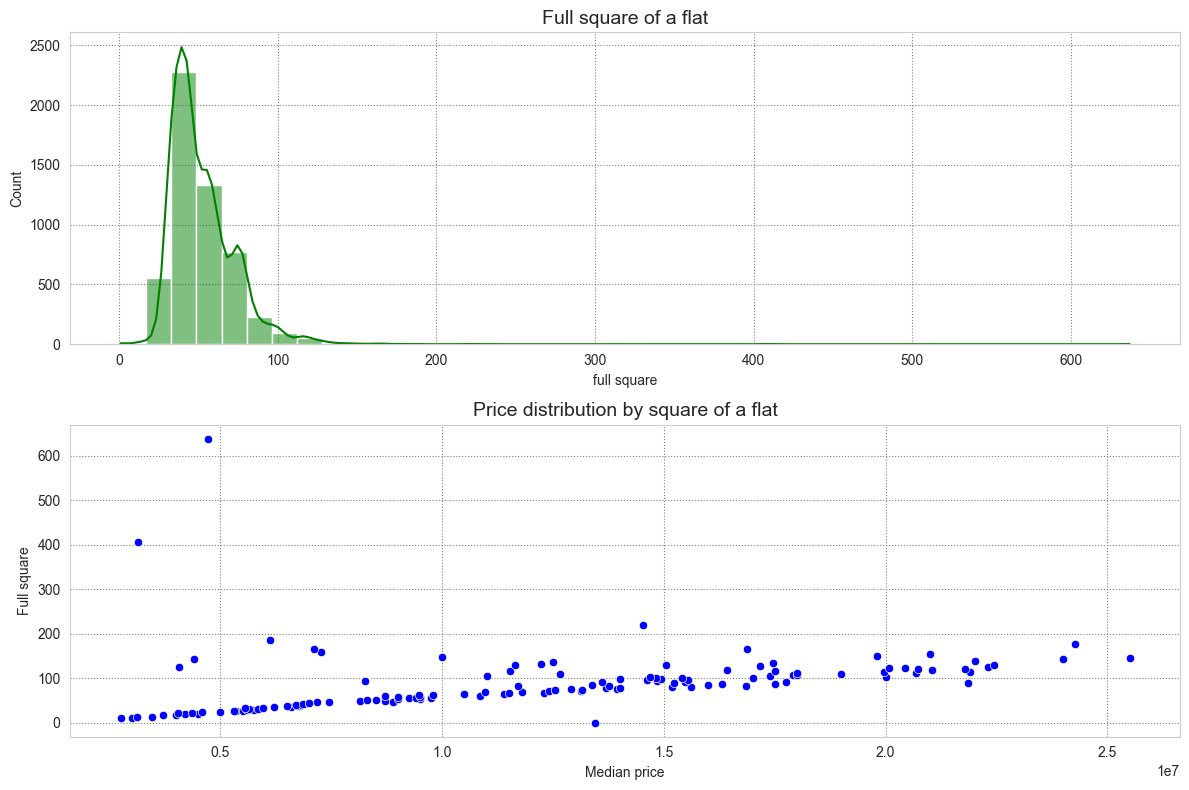

In [13]:
# сгруппируем цены по площади
square = data.groupby('full_sq')['price_doc'].median()
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# гистограмма распределения площади квартир
sns.histplot(x=data['full_sq'], kde=True, color='green', bins=40, ax = ax[0])
ax[0].set_title('Full square of a flat', fontsize=14)
ax[0].set_xlabel('full square')
# диаграмма рассеяния стоимости квартир в зависимости от площади
sns.scatterplot(x=square.values, y=square.index, color='blue', ax = ax[1])
ax[1].set_xlabel('Median price')
ax[1].set_ylabel('Full square')
ax[1].set_title('Price distribution by square of a flat', fontsize=14)
plt.tight_layout()
plt.show()

График отражает плавный рост стоимости квартиры при увеличении ее площади, наблюдаем аномально низкую стоимость квартиры с огромной площадью более 600 $м^2$.

**6. Распределение цен на квартиры в зависимости от обоих факторов (площади и количества комнат).**

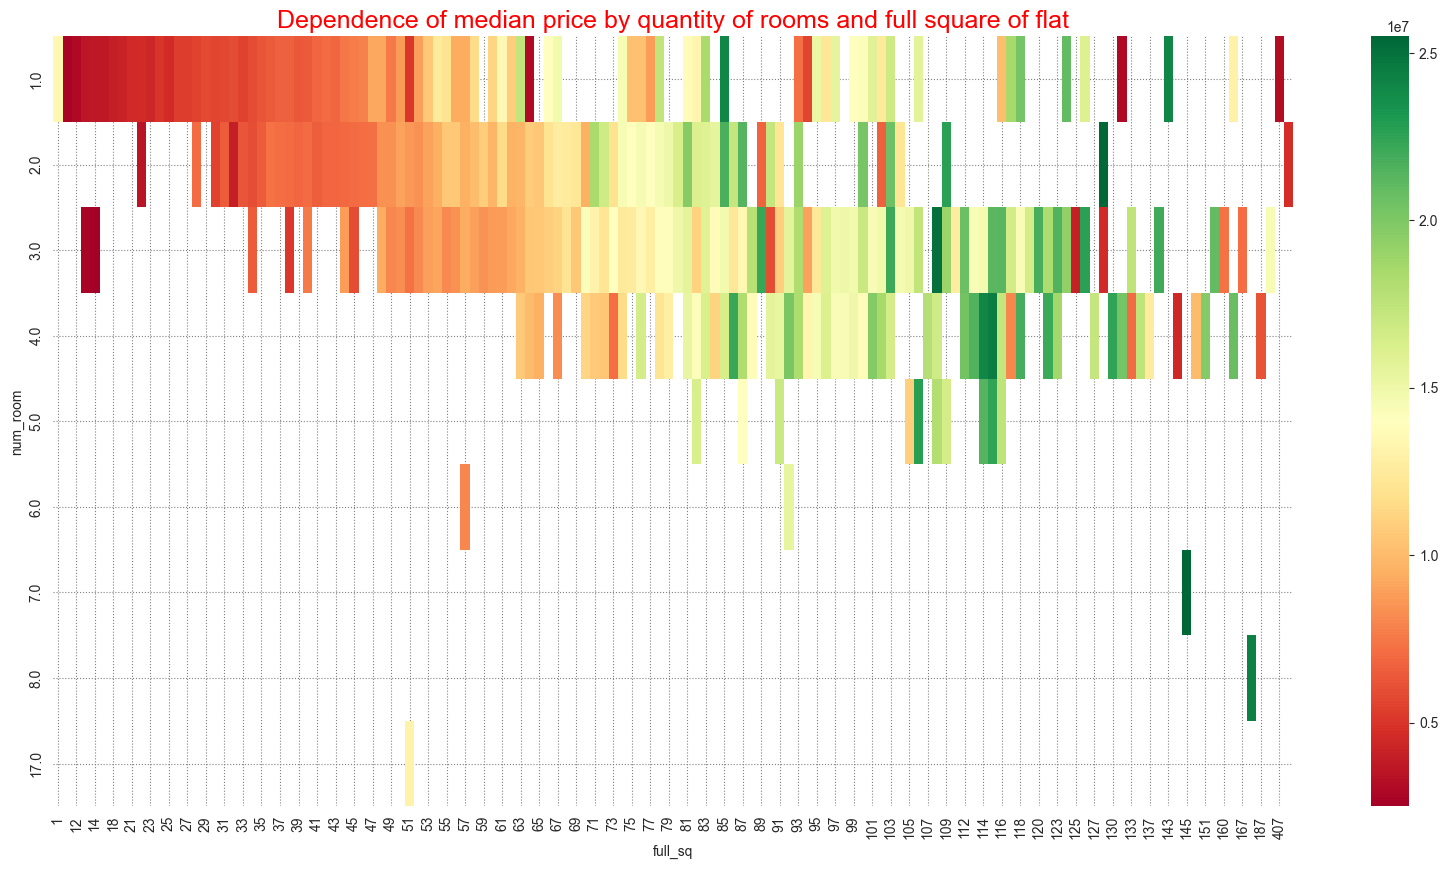

In [14]:
# создаем сводную таблицу
pivot = data.pivot_table(index='num_room', columns='full_sq', values='price_doc', aggfunc='median')

fig = plt.figure(figsize=(20,10))
# отобразим полученную таблицу на тепловой карте
p = sns.heatmap(pivot, cmap='RdYlGn', annot=False)
plt.title('Dependence of median price by quantity of rooms and full square of flat', fontsize=18, color='r')
plt.show()

Мы видим много аномалий:
* при площади 50-60 кв.м указано 6 и 17 комнат;
* для многих квартир указана слишком маленькая площадь;
* квартира с огромной площадью и очень низкой стоимостью и т.д.

Давайте проверим эти значения в наших данных.

In [15]:
data[data['full_sq']<25]

,price_doc,full_sq,num_room,kitch_sq,price_log
0,2750000,11,1.0,12.0,14.827111
111,3700000,17,1.0,3.0,15.123843
234,4100000,23,1.0,3.0,15.226498
249,6000000,21,1.0,3.0,15.607270
269,3725000,24,1.0,3.0,15.130577
457,2500000,14,3.0,8.0,14.731801
642,4200000,20,1.0,2.0,15.250595
724,4700000,23,1.0,5.0,15.363073
1048,4650000,22,1.0,3.0,15.352378
1122,3600000,20,1.0,3.0,15.096444


Да, мы встречаем очень маленькие площади 11-20 $м^2$, возможно, это продажа комнат, так как наблюдаем стоимость ниже, чем при размере площади от 20 $м^2$.\
Но 5 квартир указано с площадью 1, поменяем их площадь на среднее значение площадей квартир с соответствующей стоимостью.

In [16]:
search_price = data[data['full_sq']==1]['price_doc'].median()
print("Цена: ", search_price)
# посмотрим площадь квартир той же стоимости
mask = (data['price_doc'] < search_price+50000)&(data['price_doc'] > search_price-50000)
full_sq = data[mask]['full_sq'].median()
kitch_sq = data[mask]['kitch_sq'].median()
print('Медианные значения площадей общей и кухни для квартир, стоимость которых примерно та же, но указаны неверно параметры: ',
      full_sq, '/', kitch_sq)

Цена:  13452318.0
Медианные значения площадей общей и кухни для квартир, стоимость которых примерно та же, но указаны неверно параметры:  68.0 / 9.0


In [17]:
data.loc[data['full_sq'] == 1, 'full_sq'] = full_sq
data.loc[data['full_sq'] == 1, 'kitch_sq'] = kitch_sq

Квартиры с небольшой площадью и большим количеством комнат

In [18]:
mask_2 = (data['full_sq']<59)&(data['num_room']>5)
data[mask_2]

,price_doc,full_sq,num_room,kitch_sq,price_log
2894,8000000,57,6.0,6.0,15.894952
4977,13150000,51,17.0,8.0,16.391932


По той же схеме определяем среднее значение и заменяем.

In [19]:
room_mask = data['full_sq'].between(51, 59)
num = data[room_mask]['num_room'].median()
data.loc[mask_2, 'num_room'] = num
data[mask_2]

,price_doc,full_sq,num_room,kitch_sq,price_log
2894,8000000,57,2.0,6.0,15.894952
4977,13150000,51,2.0,8.0,16.391932


Квартира с самой большой площадью и низкой стоимостью.

In [20]:
mask_3 = data['full_sq'].max()
data[data['full_sq']==mask_3]

,price_doc,full_sq,num_room,kitch_sq,price_log
3898,4725142,637,2.0,10.0,15.368408


Данный объект точно ошибочный: 2 комнаты при такой площади и такая низкая цена.\
Чтобы этf ошибка не повлияла на качество модели, мы ее исключим.

In [21]:
data.drop(index=data[data['full_sq'] == mask_3].index, inplace=True)

Мы проверили совсем немного аномальных значений, на самом деле данный набор требует уточнения и перепроверки параметров, например, в комнатах размером 14-15 кв.м обозначено 3 комнаты.\
Но мы переходим к моделированию, так как наша цель: сравнить разные подходы построения линейной регрессии.

**7. Нормализация факторов**.

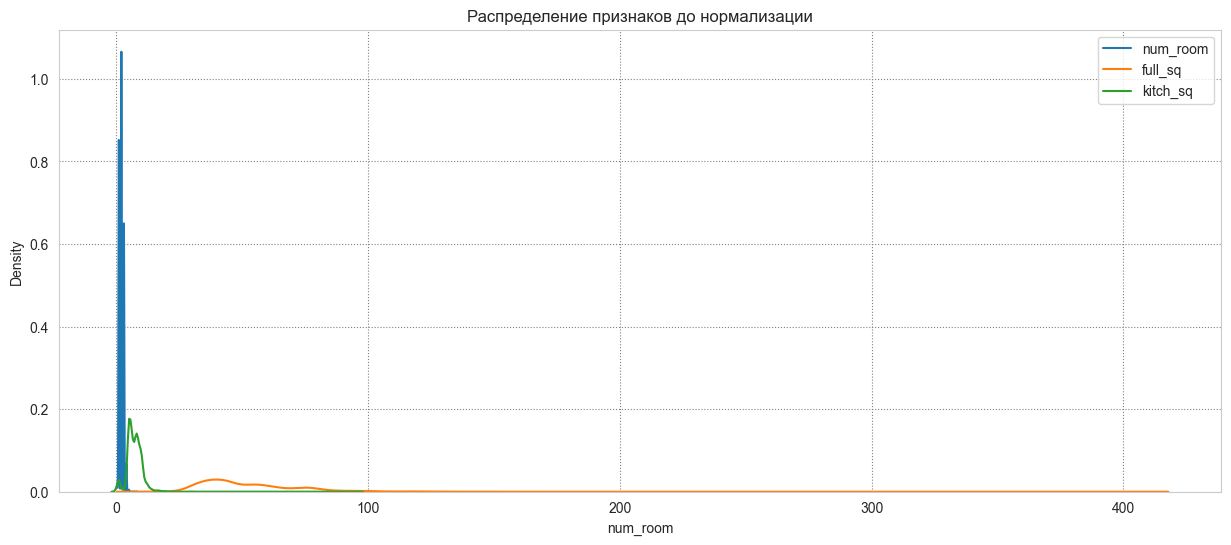

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 6))
ax.set_title('Распределение признаков до нормализации')
sns.kdeplot(data['num_room'], ax=ax, label ='num_room')
sns.kdeplot(data['full_sq'], ax=ax, label ='full_sq')
sns.kdeplot(data['kitch_sq'], ax=ax, label = 'kitch_sq')
plt.legend()
plt.show()

In [23]:
# масштабируем предикаты, чтобы наша модель лучше распознала зависимости
scaler = preprocessing.MinMaxScaler()
data[['num_room', 'full_sq', 'kitch_sq']] = scaler.fit_transform(data[['num_room', 'full_sq', 'kitch_sq']])

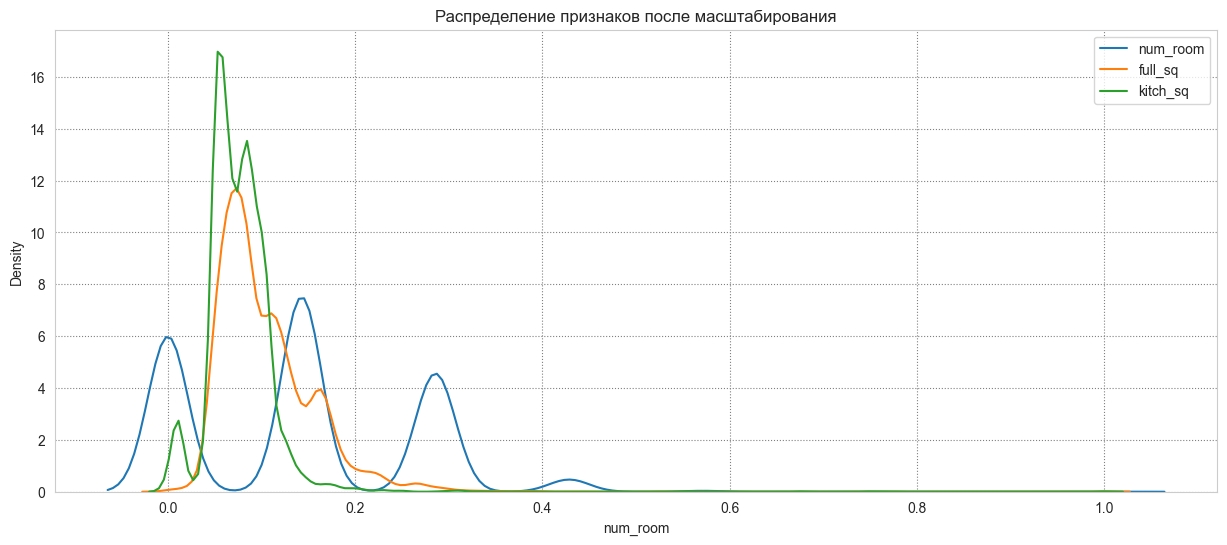

In [24]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 6))
ax.set_title('Распределение признаков после масштабирования')
sns.kdeplot(data['num_room'], ax=ax, label ='num_room')
sns.kdeplot(data['full_sq'], ax=ax, label ='full_sq')
sns.kdeplot(data['kitch_sq'], ax=ax, label = 'kitch_sq')
plt.legend()
plt.show()

**8. Байесовская линейная регрессия**.

Априорные распределения:
* $\alpha \sim \mathcal{N}(\mu=0,\sigma=10)$
* $\beta[i] \sim \mathcal{N}(\mu=0,\sigma=10)$, where $i=1$
* $\sigma \sim \textrm{half-normal}(\sigma=1)$

Определим ожидаемое значение:
\begin{equation}
  \text{Y} = \alpha + \beta*X
\end{equation}

Байесовская вероятностная модель определяется следующим образом:

\begin{equation}
  \text{Y}\sim \mathcal{N}(\mu=\mu,\sigma=\sigma).
\end{equation}

Это означает, что $Y$ нормально распределено со средним значением $\alpha +  X \cdot \beta$ (величина, которую мы предсказываем) и некоторым стандартным отклонением σ.

Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\envs\pymc4_env\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, sigma]


Output()

Sampling 2 chains for 1_000 tune and 5_348 draw iterations (2_000 + 10_696 draws total) took 43 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


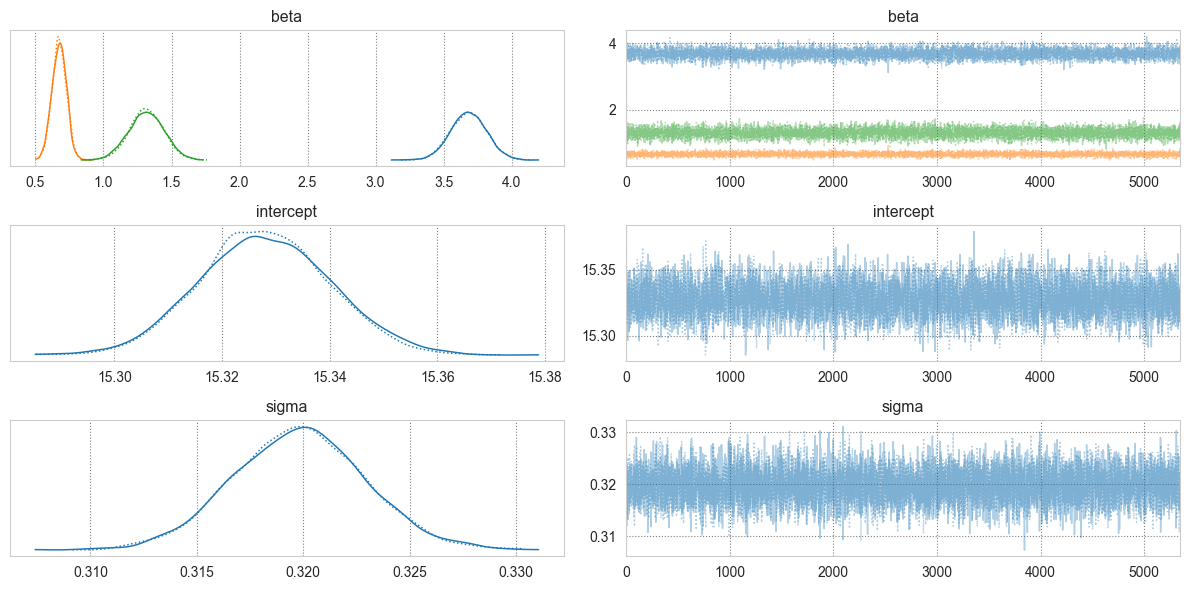

In [25]:
X = data[["full_sq", "num_room", "kitch_sq"]].values
y = data["price_log"].values

# определяем модель
with pm.Model() as bayes_model:
    # априорные распределения для коэффициентов
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10) # альфа
    # Ошибка модели
    sigma = pm.HalfNormal("sigma", sigma=1)
    # линейное предсказание
    mu = intercept + pm.math.dot(X, beta)
    
    # лог-нормальное распределение стоимости
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # запуск сэмплера MCMC, tune - количество итераций, target_accept – целевая вероятность принятия нового шага в алгоритме
    trace = pm.sample(X.shape[0], tune=1000, target_accept=0.9)
    
# выведем распределение
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [26]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],3.684,0.130,3.438,3.926,0.002,0.001,5573.0,6558.0,1.0
beta[1],0.674,0.053,0.576,0.772,0.001,0.000,6780.0,7213.0,1.0
beta[2],1.316,0.126,1.076,1.552,0.002,0.001,6422.0,7159.0,1.0
intercept,15.328,0.012,15.305,15.350,0.000,0.000,5498.0,6695.0,1.0
sigma,0.320,0.003,0.314,0.326,0.000,0.000,11198.0,7374.0,1.0


Соответственно коэффициенты beta[0] - full_sq, beta[1] - num_room, beta[2] - kitch_sq

Sampling: [y_obs]


Output()

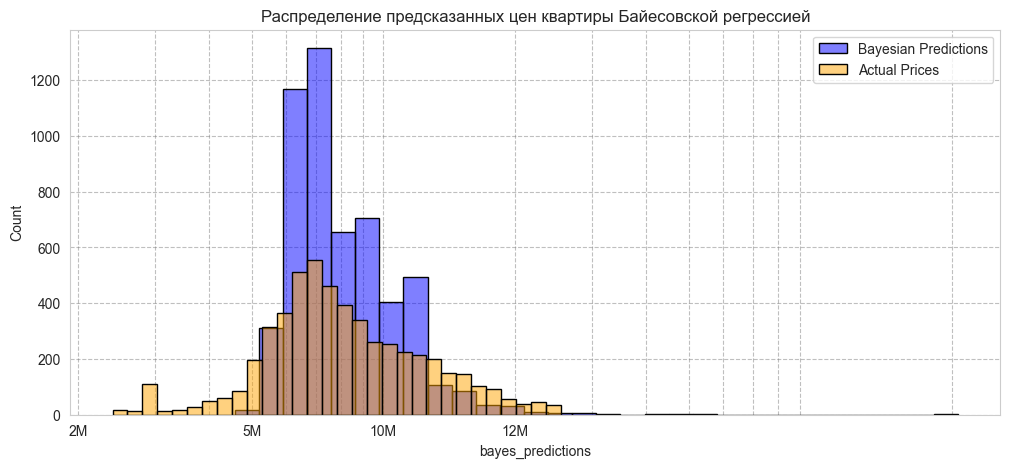

In [27]:
# сделаем предсказания
with bayes_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, predictions=True)

# Извлекаем предсказанные значения логарифма цены
predicted_prices_log = posterior_predictive["predictions"]["y_obs"].mean(dim=("chain", "draw")).values

# преобразуем логарифм обратно в цену
predicted_prices = np.exp(predicted_prices_log)
data['bayes_predictions'] = predicted_prices  

# визуализируем распределение предсказанных цен
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data['bayes_predictions'], bins=30, alpha=0.5, color="blue", edgecolor="black", log_scale=True, ax=ax)
sns.histplot(data['price_doc'], bins=30, alpha=0.5, color="orange", edgecolor="black", log_scale=True, ax=ax)
# настройка оси X
ax.set_xticks([2e6, 5e6, 1e7, 2e7])  # указываем основные точки
ax.set_xticklabels(["2M", "5M", "10M", "12M"])  # переминуем их в формат цены в миллионах

plt.title("Распределение предсказанных цен квартиры Байесовской регрессией")
plt.legend(["Bayesian Predictions", "Actual Prices"])
plt.grid(True, which="both", linestyle="--", alpha=0.5)  # Добавляем прозрачную сетку
plt.show()

In [28]:
# сделаем предсказание для одной квартиры: квартира 50 м2, 2 комнаты, кухня 10 м2
new_data = pd.DataFrame({"num_room": [2], "full_sq": [50], "kitch_sq": [10]})

# Применяем масштабирование
new_scaled = scaler.transform(new_data)  # new_scaled теперь NumPy-массив

# Извлекаем средние значения параметров модели из trace
intercept_mean = trace.posterior["intercept"].mean().item()
beta_means = trace.posterior["beta"].mean(dim=["chain", "draw"]).values  # Средние коэффициенты

# Вычисляем логарифм предсказанной цены
predicted_price_log = intercept_mean + np.dot(new_scaled, beta_means)

# Преобразуем обратно в обычную цену
pred_price_bayes = np.exp(predicted_price_log)

print(f"Предсказанная цена квартиры: {pred_price_bayes[0]:,.2f}")

Предсказанная цена квартиры: 9,413,117.93


Также для создания байесовской регрессионной модели мы можем воспользоваться библиотекой Bambi.\
Bambi автоматически задаёт априорные распределения для коэффициентов на основе статистических свойств данных.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, full_sq, num_room, kitch_sq]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


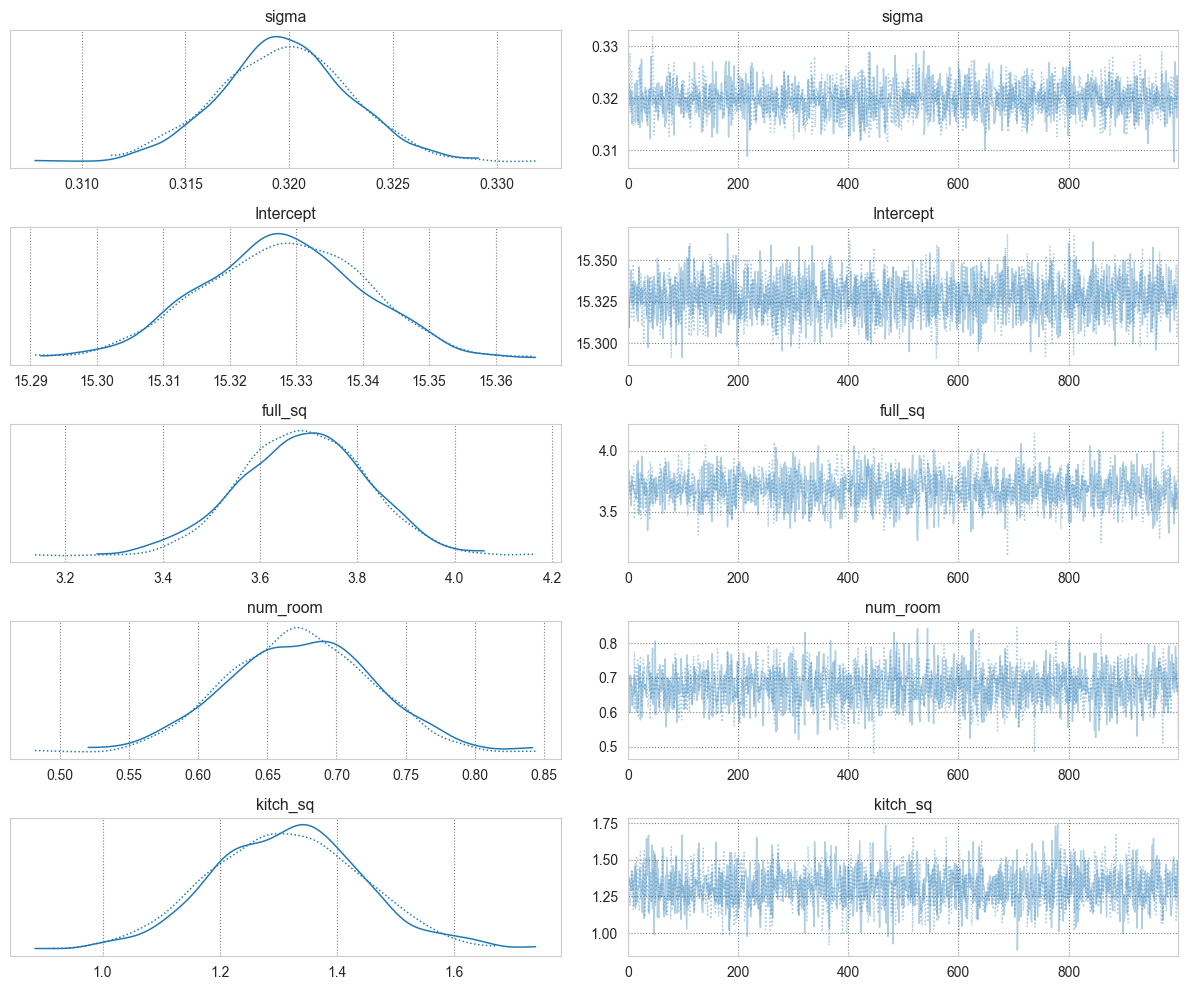

In [29]:
# cоздание модели с Bambi
bayes_model_2 = bmb.Model("price_log ~ full_sq + num_room + kitch_sq", data)
# аппроксимация методом выборки
trace_2 = bayes_model_2.fit(draws=1000) # draws=1000: означает, что будет сделано 1000 выборок из апостериорного распределения параметров модели

# Графики параметров
az.plot_trace(trace_2)
plt.tight_layout()
plt.show()

In [30]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.320,0.003,0.313,0.325,0.000,0.000,2008.0,1592.0,1.0
Intercept,15.328,0.012,15.307,15.351,0.000,0.000,2977.0,1726.0,1.0
full_sq,3.689,0.130,3.434,3.920,0.003,0.002,1817.0,1580.0,1.0
num_room,0.673,0.053,0.579,0.775,0.001,0.001,1929.0,1653.0,1.0
kitch_sq,1.313,0.128,1.081,1.565,0.003,0.002,2015.0,1566.0,1.0


c:\ProgramData\anaconda3\envs\pymc4_env\Lib\site-packages\arviz\plots\lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


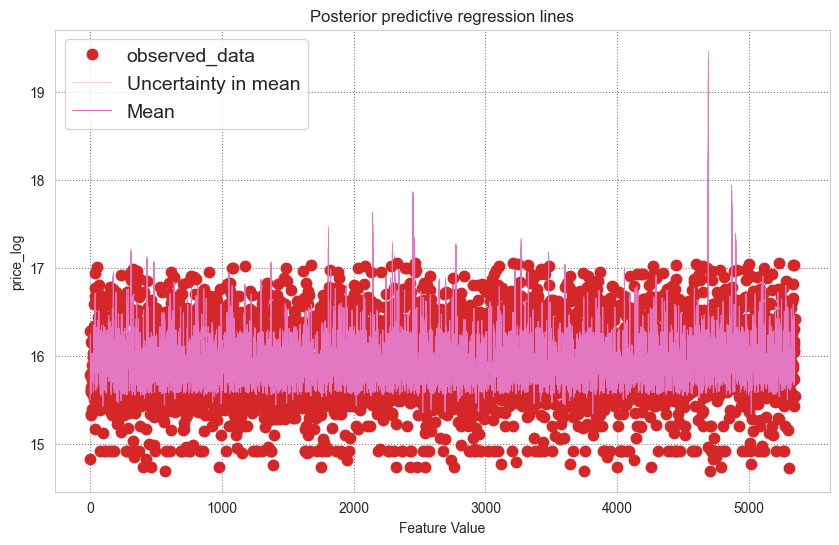

In [31]:
import xarray as xr

# Преобразуем данные в DataArray с правильными измерениями
num_room = xr.DataArray(data["num_room"], dims="obs")
full_sq = xr.DataArray(data["full_sq"], dims="obs")
kitch_sq = xr.DataArray(data["kitch_sq"], dims="obs")

# предсказание y_model на основе апостериорных параметров
trace_2.posterior["y_model"] = (
    trace_2.posterior["Intercept"] +
    trace_2.posterior["num_room"] * num_room +
    trace_2.posterior["full_sq"] * full_sq +
    trace_2.posterior["kitch_sq"] * kitch_sq
)

# визуализация предсказаний
_, ax = plt.subplots(figsize=(10, 6))
az.plot_lm(idata=trace_2, y="price_log", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("Feature Value") 
plt.show()

Разброс линий отображает неопределенность модели, тем самым и неопределенность в предсказаниях. Линии приближены друг к другу и повторяют фактические значения. Модель уловила зависимости.

**9. Классическая линейная регрессия**

In [32]:
lr = LinearRegression()
lr.fit(data[['full_sq', 'num_room',  'kitch_sq']], data['price_log'])
print('Intercept: ', lr.intercept_)
pd.DataFrame(lr.coef_, index=['full_sq', 'num_room',  'kitch_sq'])

Intercept:  15.327904666039627


,0
full_sq,3.684529
num_room,0.673585
kitch_sq,1.315383


c:\ProgramData\anaconda3\envs\pymc4_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


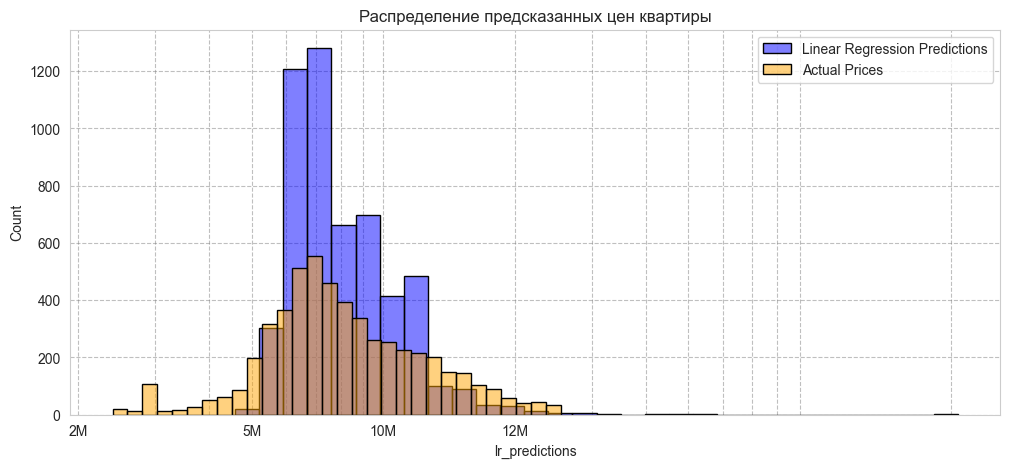

In [33]:
# сделаем предсказание и преобразуем обратно из логарифма
data['lr_predictions'] = np.exp(lr.predict(X))
# Визуализируем распределение предсказанных цен
fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(data['lr_predictions'], bins=30, alpha=0.5, color="blue", edgecolor="black", log_scale=True, ax=ax)
sns.histplot(data['price_doc'], bins=30, alpha=0.5, color="orange", edgecolor="black", log_scale=True, ax=ax)

# Настройка оси X
ax.set_xticks([2e6, 5e6, 1e7, 2e7])  # указываем основные точки
ax.set_xticklabels(["2M", "5M", "10M", "12M"])  # Преобразуем их в удобочитаемый формат

plt.title("Распределение предсказанных цен квартиры")
plt.legend(["Linear Regression Predictions", "Actual Prices"])
plt.grid(True, which="both", linestyle="--", alpha=0.5)  # Добавляем прозрачную сетку

plt.show()

In [34]:
# сделаем предсказание для одной квартиры: квартира 50 м2, 2 комнаты, кухня 10 м2
new_data = pd.DataFrame({"num_room": [2], "full_sq": [50], "kitch_sq": [10]})
new_data = scaler.transform(new_data)
pred_price_lr = lr.predict(new_data)
print(f'Цена квартиры с параметрами: общая площадь - 50, площадь кухни-10, 2 комнаты: {np.exp(pred_price_lr)[0]:,.2f}')

Цена квартиры с параметрами: общая площадь - 50, площадь кухни-10, 2 комнаты: 9,413,193.34


c:\ProgramData\anaconda3\envs\pymc4_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


**10. Сравнительный анализ параметров байесовской регрессии и классической линейной регрессии.**

In [35]:
parameters = pd.DataFrame({
    'Bayes Regression': pm.summary(trace)['mean'][:-1].tolist(),
    'Linear Regression': [*lr.coef_.tolist(), lr.intercept_],
}, index = ['coef full_sq', 'coef num_room', 'coef kitch_sq', 'intercept'])
parameters

,Bayes Regression,Linear Regression
coef full_sq,3.684,3.684529
coef num_room,0.674,0.673585
coef kitch_sq,1.316,1.315383
intercept,15.328,15.327905


In [36]:
# напомним предсказания для придуманной квартиры обеих моделей
print('Bayes regression: ', round(pred_price_bayes[0]))
print('Linear regression: ', round(np.exp(pred_price_lr)[0]))

Bayes regression:  9413118
Linear regression:  9413193


#### <center> Заключение
1. Мы наблюдаем практически идентичные значения коэффициентов, что говорит о согласованности методов.
2. Оба метода указывают, что площадь играет ключевую роль для определения цены.

Так как значения средних коэффициентов в байесовской модели очень близки к классической линейной регрессии, можно сделать вывод, что данные хорошо соответствуют линейной зависимости.